In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [118]:

# Load the dataset
data = pd.read_csv('train.csv') 

# Convert 'Date' column to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

# group by month
#data['Date'] = data['Order Date'].dt.to_period('M')
#preprocessed_data = data.groupby(['Date', 'Category'], as_index=False)['Sales'].sum()
#preprocessed_data = preprocessed_data[['Date', 'Category', 'Sales']]


# group by day
preprocessed_data = data.groupby(['Order Date', 'Category'], as_index=False)['Sales'].sum()

preprocessed_data = preprocessed_data[['Order Date', 'Category', 'Sales']]

# Display preprocessed data
print(preprocessed_data.head())

# List of unique categories



  Order Date         Category     Sales
0 2015-01-03  Office Supplies    16.448
1 2015-01-04  Office Supplies   288.060
2 2015-01-05  Office Supplies    19.536
3 2015-01-06        Furniture  2573.820
4 2015-01-06  Office Supplies   685.340


In [119]:
def moving_average(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    forecast_values = category_data['Sales'].rolling(window=5).mean()

    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Moving Average ('{category}')")
    plt.legend()
    plt.title(f'Moving Average Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
    category_data['Sales']
    mse = mean_squared_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mae = mean_absolute_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mape = mean_absolute_percentage_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def exponential_smoothing(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    forecast_values = SimpleExpSmoothing(category_data['Sales']).fit(
        smoothing_level=0.2, optimized=False).fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Exponential Smoothing ('{category}')", color = "red")
    plt.legend()
    plt.title(f'Exponential Smoothing Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def linear_regression(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    X = category_data['Order Date'].astype('int64').values.reshape(-1, 1)  # Using Order Date as the predictor
    y = category_data['Sales']
    
    model = LinearRegression().fit(X, y)
    forecast_values = model.predict(X)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Linear Regression ('{category}')", color='yellow')
    plt.legend()
    plt.title(f'Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def deseasonalized_linear_regression(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    
    # Group data by month and calculate the mean for each month
    category_data['Order Month'] = category_data['Order Date'].dt.to_period('M')
    monthly_means = category_data.groupby('Order Month')['Sales'].mean()
    
    # Repeat the monthly mean to match the length of the dataset
    full_seasonal_pattern = category_data['Order Month'].map(monthly_means)
    
    # Deseasonalize the data
    deseasonalized = category_data['Sales'] / full_seasonal_pattern
    
    # Fit linear regression to the deseasonalized data
    X = category_data['Order Date'].astype('int64').values.reshape(-1, 1)  # Using Order Date as the predictor
    model = LinearRegression().fit(X, deseasonalized)
    deseasonalized_forecast_values = model.predict(X) * full_seasonal_pattern
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], deseasonalized_forecast_values, label=f"Deseasonalized Linear Regression ('{category}')", color='green')
    plt.legend()
    plt.title(f'Deseasonalized Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], deseasonalized_forecast_values)
    mae = mean_absolute_error(category_data['Sales'], deseasonalized_forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], deseasonalized_forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def holts_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Holt's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add').fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Holt's Method ('{category}')", color='orange')
    plt.legend()
    plt.title(f"Holt's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def winters_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Winter's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add', seasonal='add', seasonal_periods=30).fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Winter's Method ('{category}')", color='green')
    plt.legend()
    plt.title(f"Winter's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

Category: Office Supplies


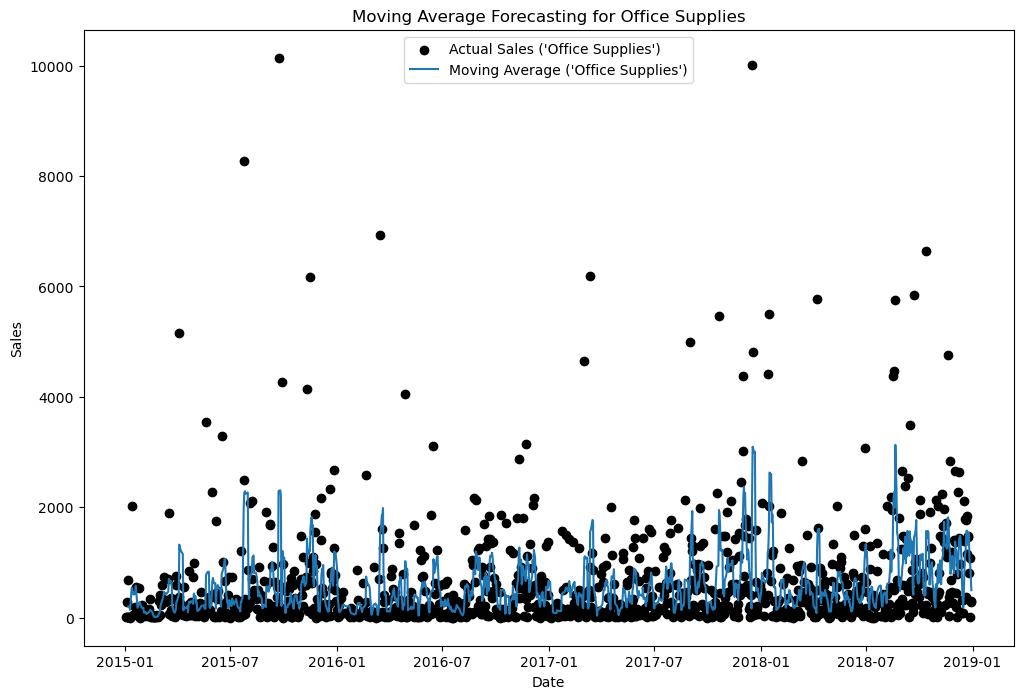

MSE: 756220.8242566619, MAE: 504.844125483304, MAPE: 5.902186719772373


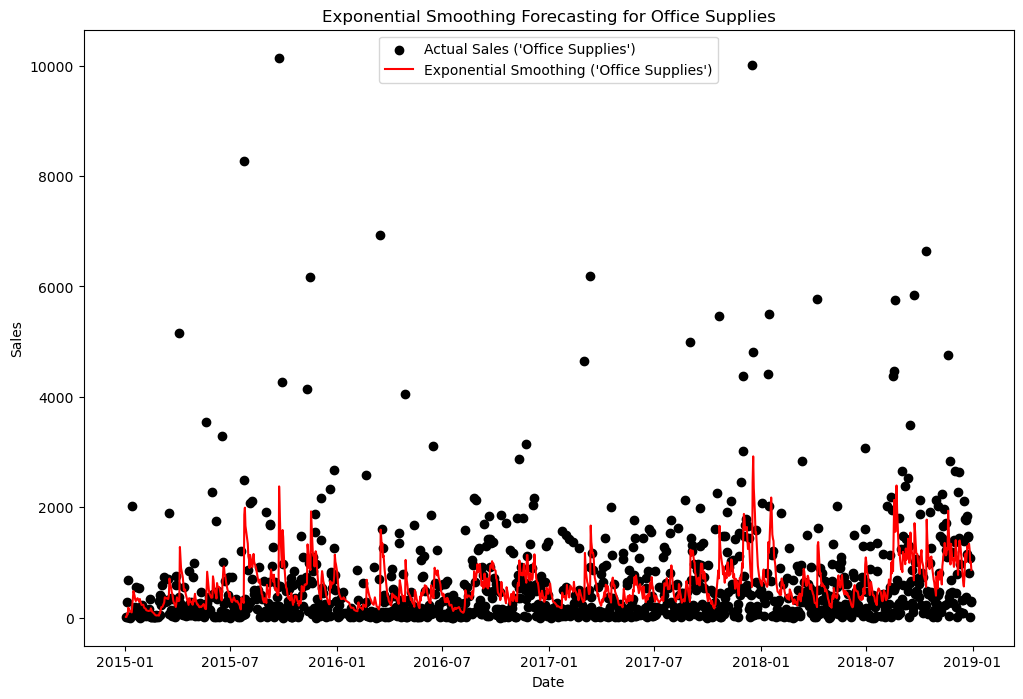

MSE: 1033418.6188976867, MAE: 589.6064944763581, MAPE: 7.360548323760049


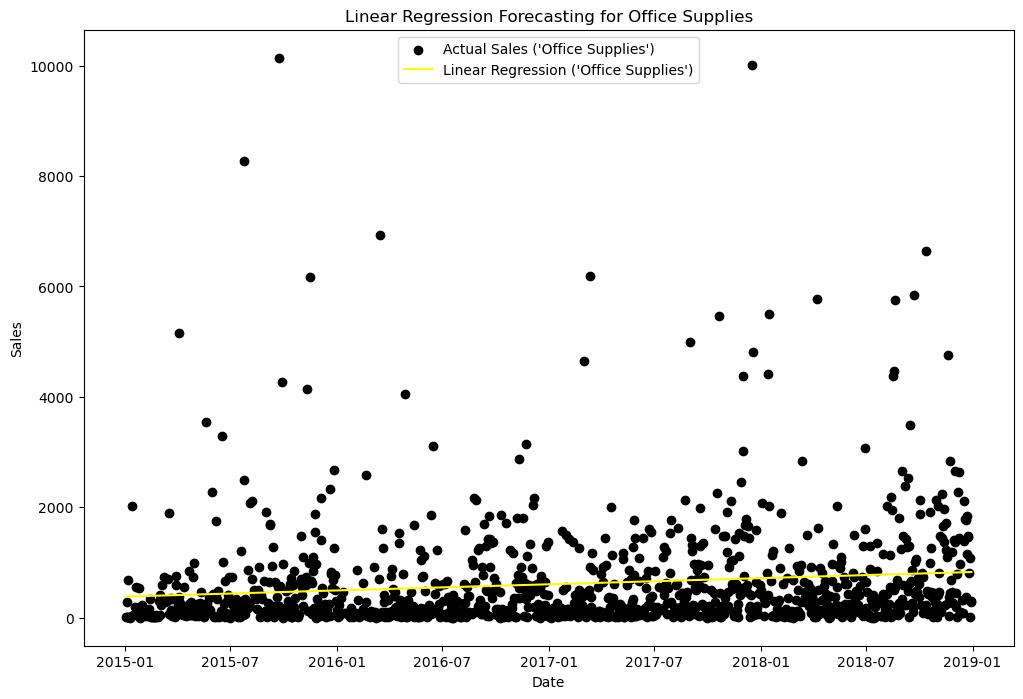

MSE: 959840.6245429893, MAE: 578.3781201662991, MAPE: 8.97030313061349


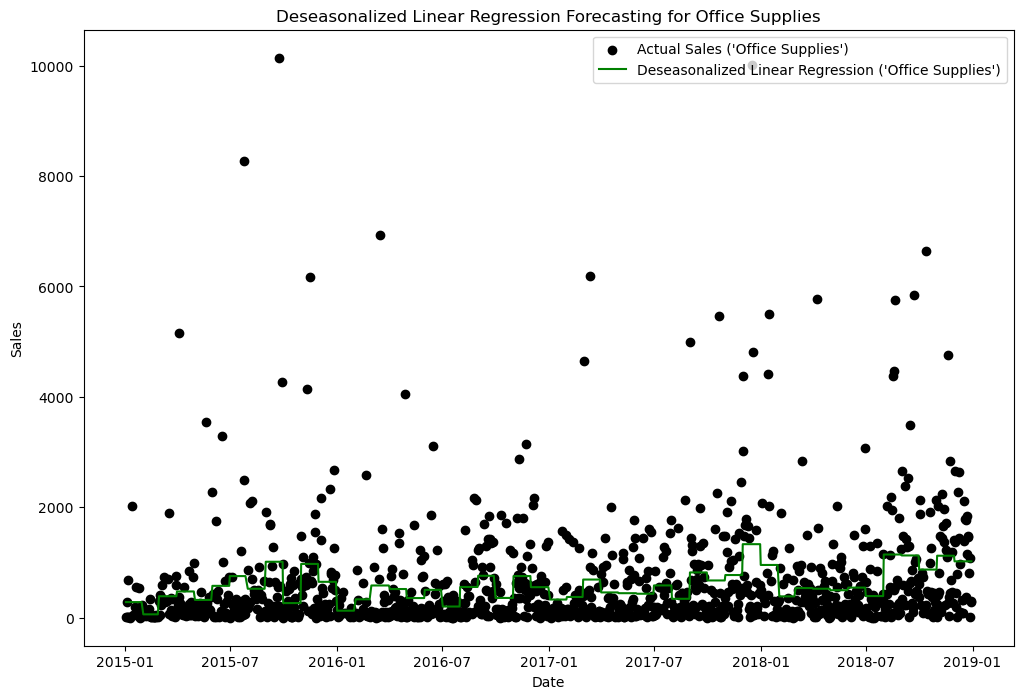

MSE: 895221.6615995865, MAE: 551.7028619078312, MAPE: 7.577437859197768


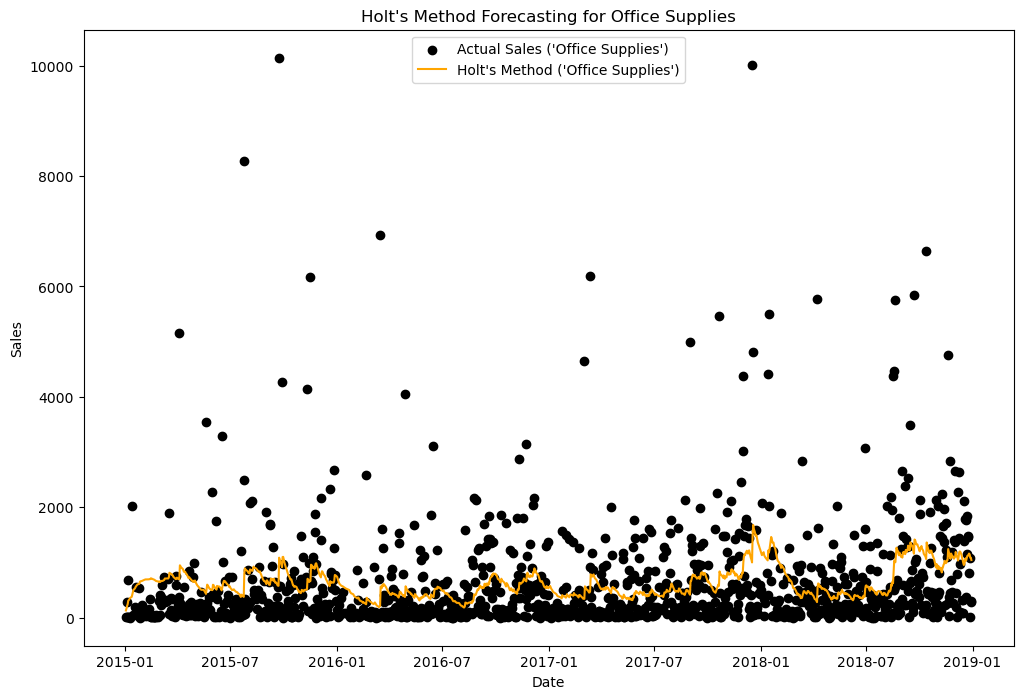

MSE: 987560.6264987055, MAE: 600.4647784724312, MAPE: 8.885765149642284


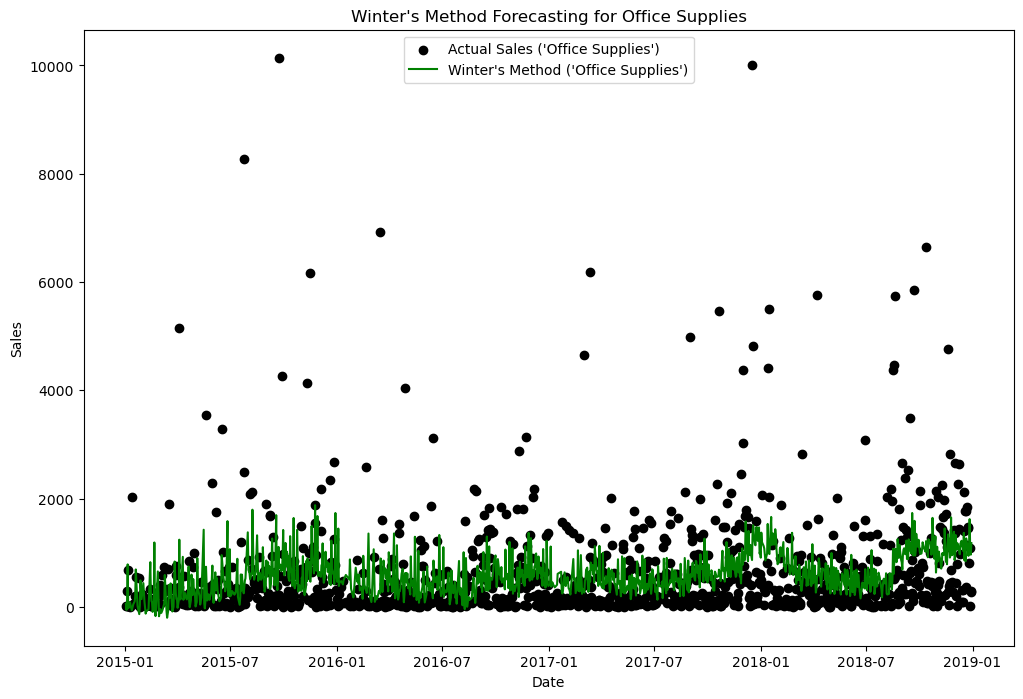

MSE: 1003664.2364787325, MAE: 594.452002569967, MAPE: 8.373710008397623
Category: Furniture


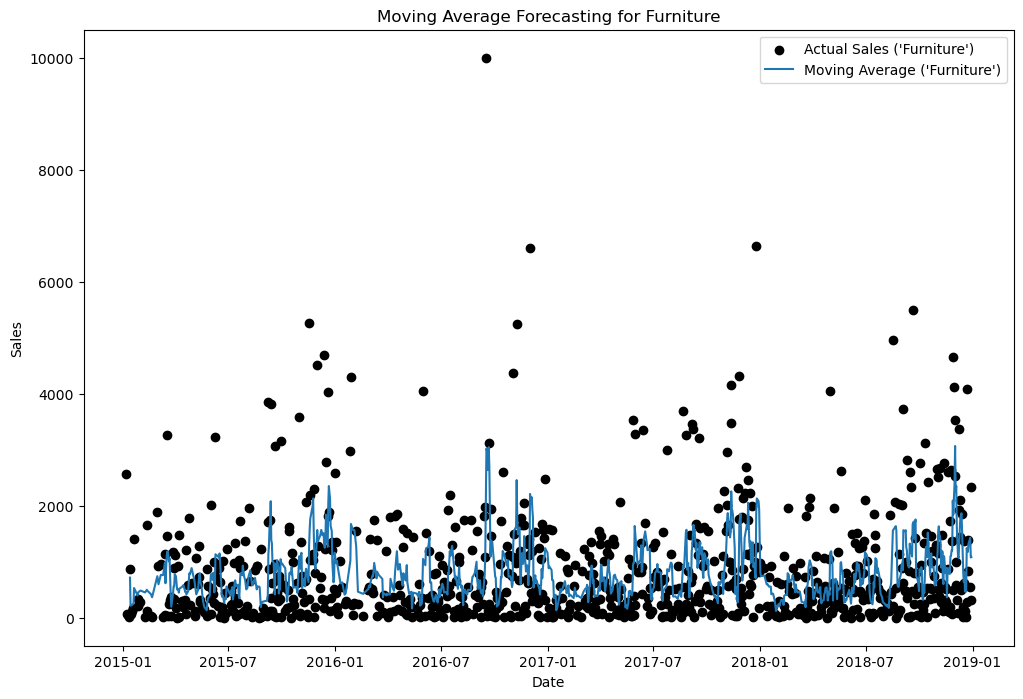

MSE: 783520.3939584856, MAE: 610.3760264678899, MAPE: 6.602820402750876


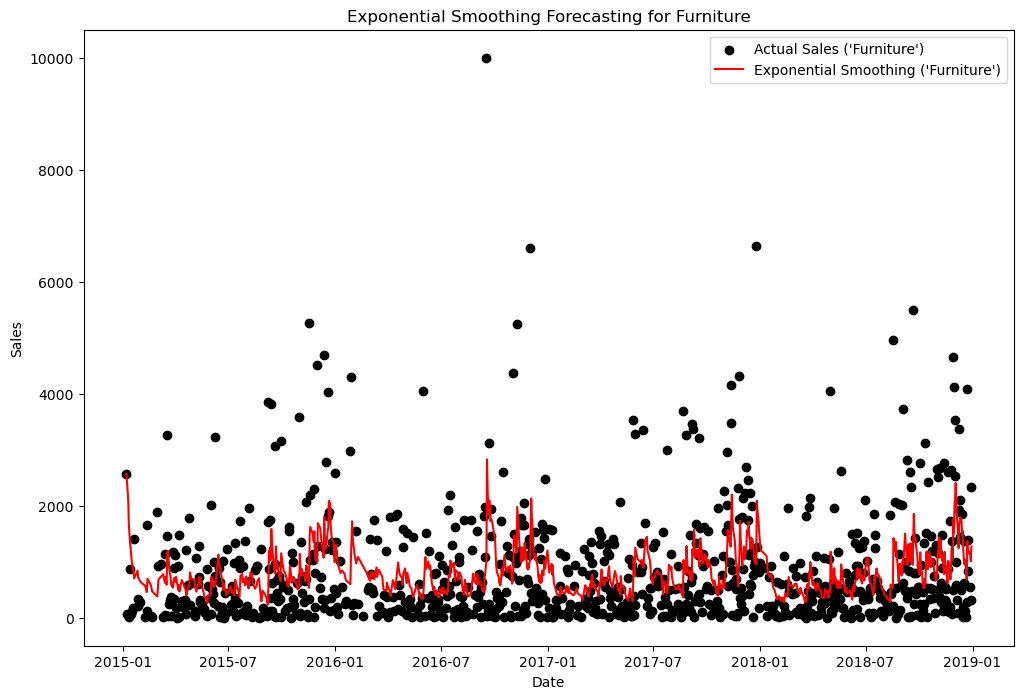

MSE: 1099837.863496326, MAE: 724.1425558783311, MAPE: 8.079040939356473


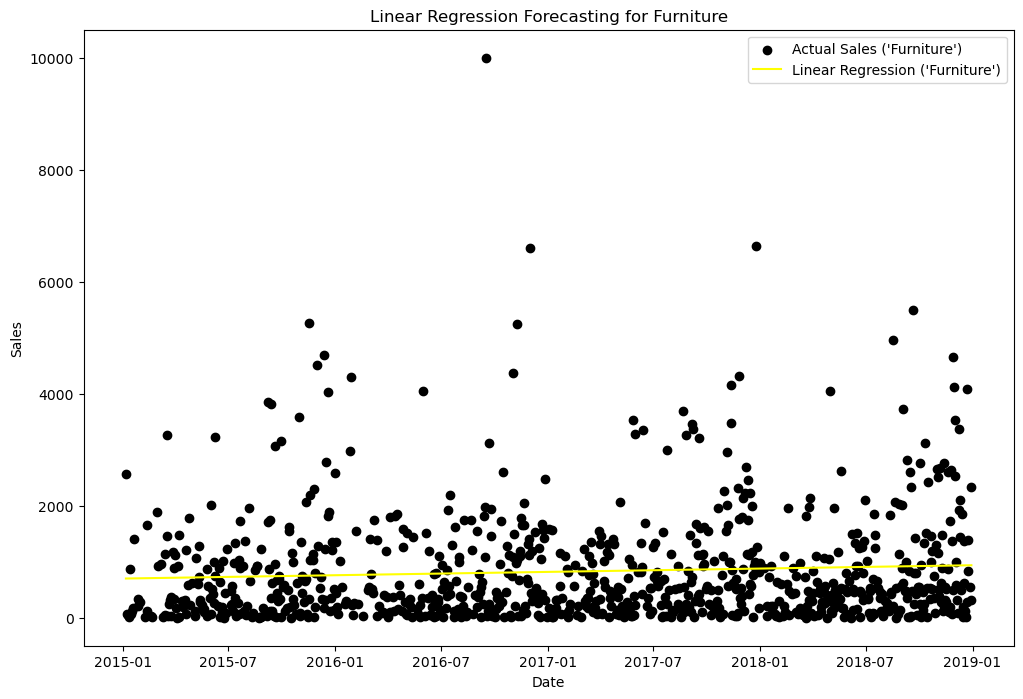

MSE: 1010831.2871451565, MAE: 696.5170415687529, MAPE: 8.332438184659829


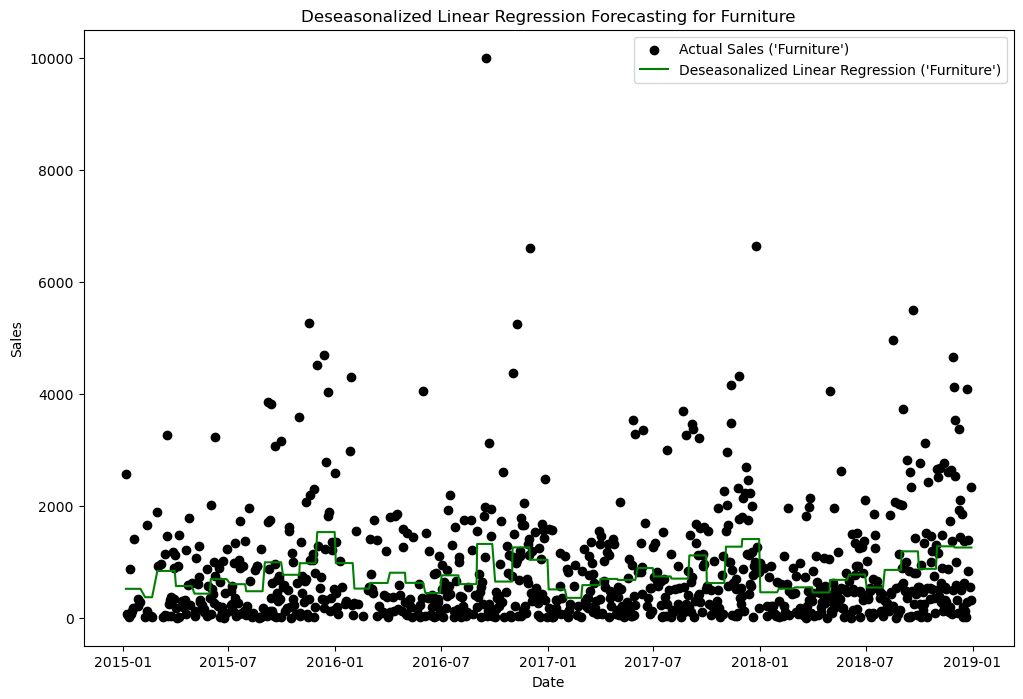

MSE: 921673.282999656, MAE: 664.0232425645037, MAPE: 7.232736469910304


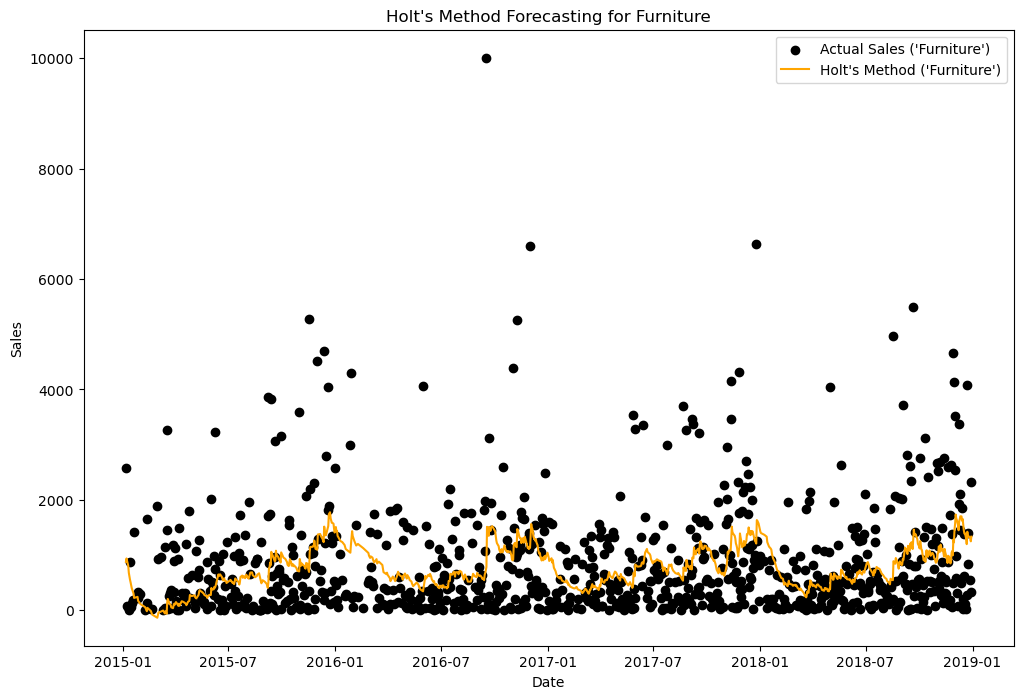

MSE: 1051814.9386133996, MAE: 702.8098298588509, MAPE: 7.144506671932952


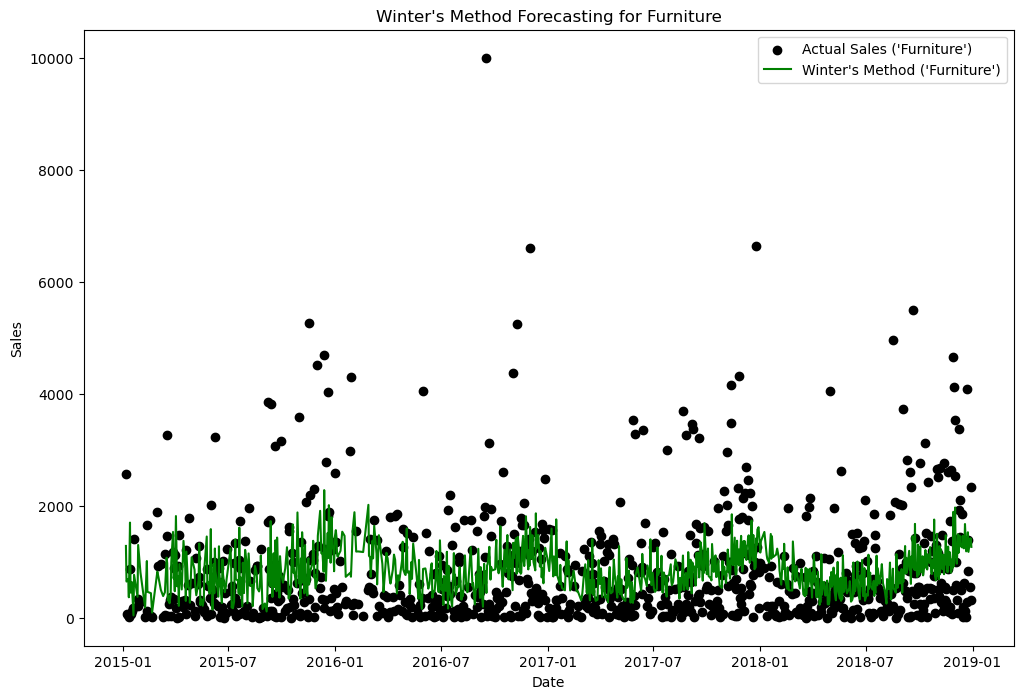

MSE: 1050473.5365755414, MAE: 699.8569235630143, MAPE: 7.66091283351187
Category: Technology


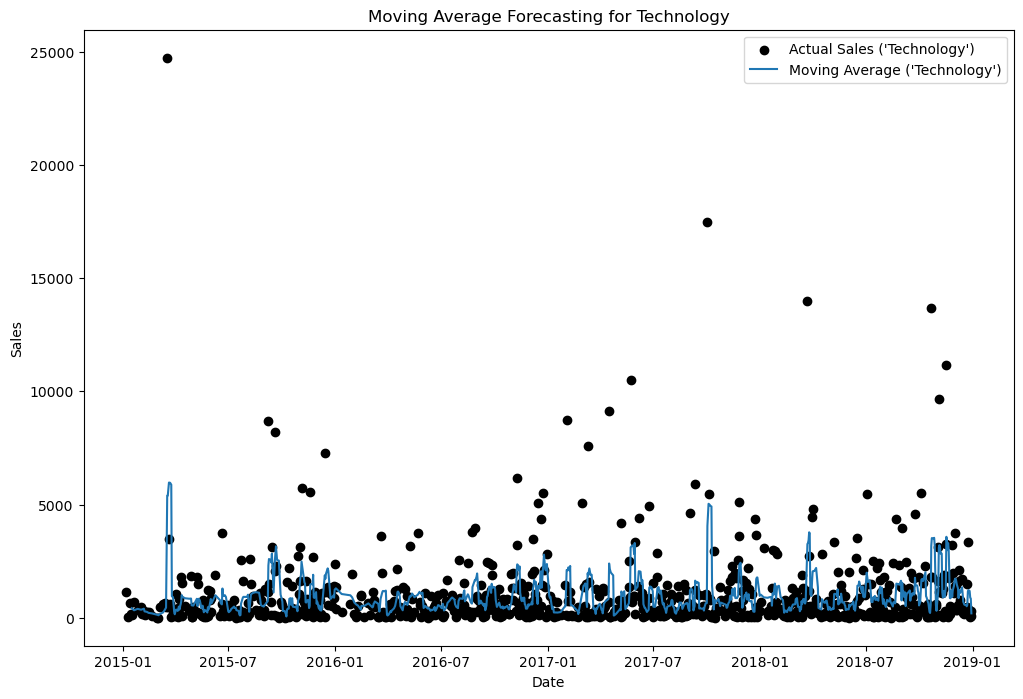

MSE: 2636588.4787474507, MAE: 880.6150958230959, MAPE: 6.751014741111343


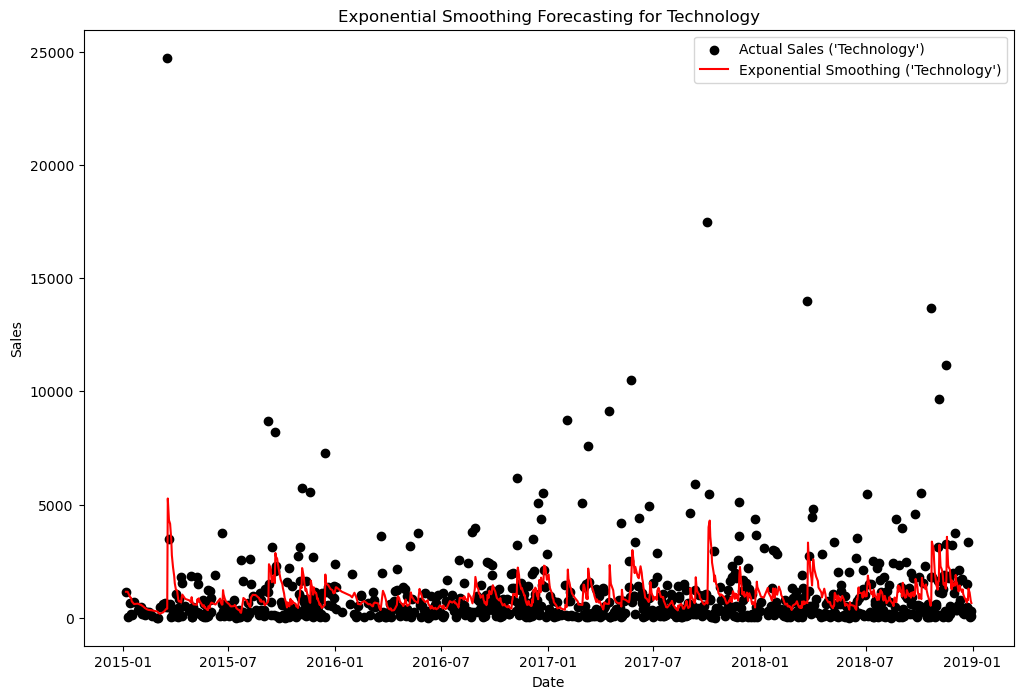

MSE: 3613644.2710770746, MAE: 1018.8622224841897, MAPE: 8.359362872472449


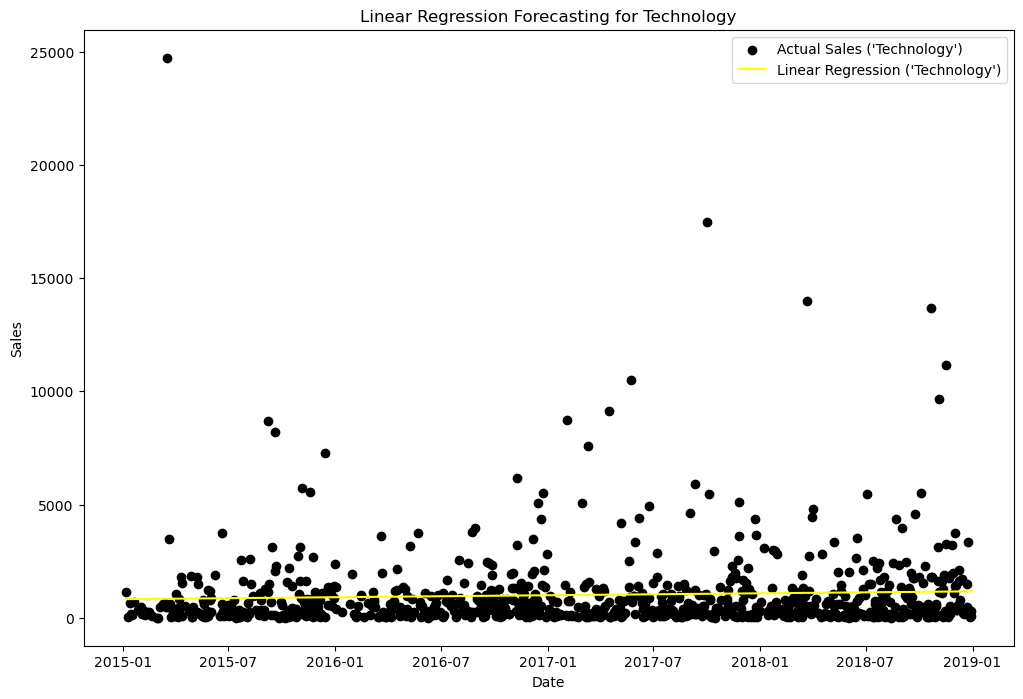

MSE: 3243377.2480110116, MAE: 949.4059849660771, MAPE: 8.787584225890495


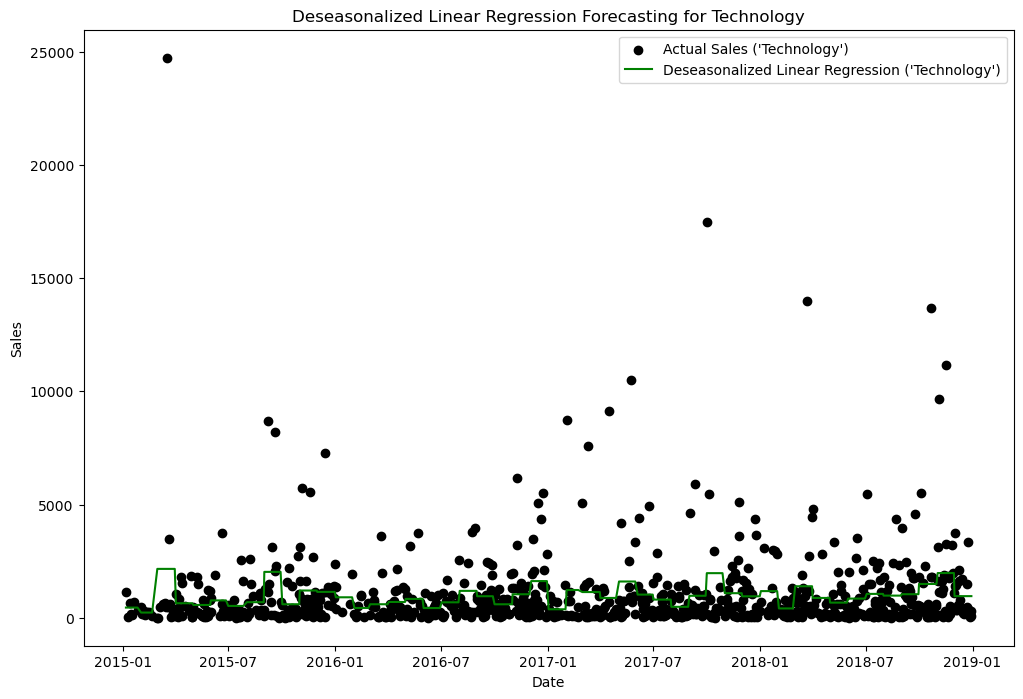

MSE: 3059324.793838878, MAE: 938.7351910089726, MAPE: 8.696576095274429


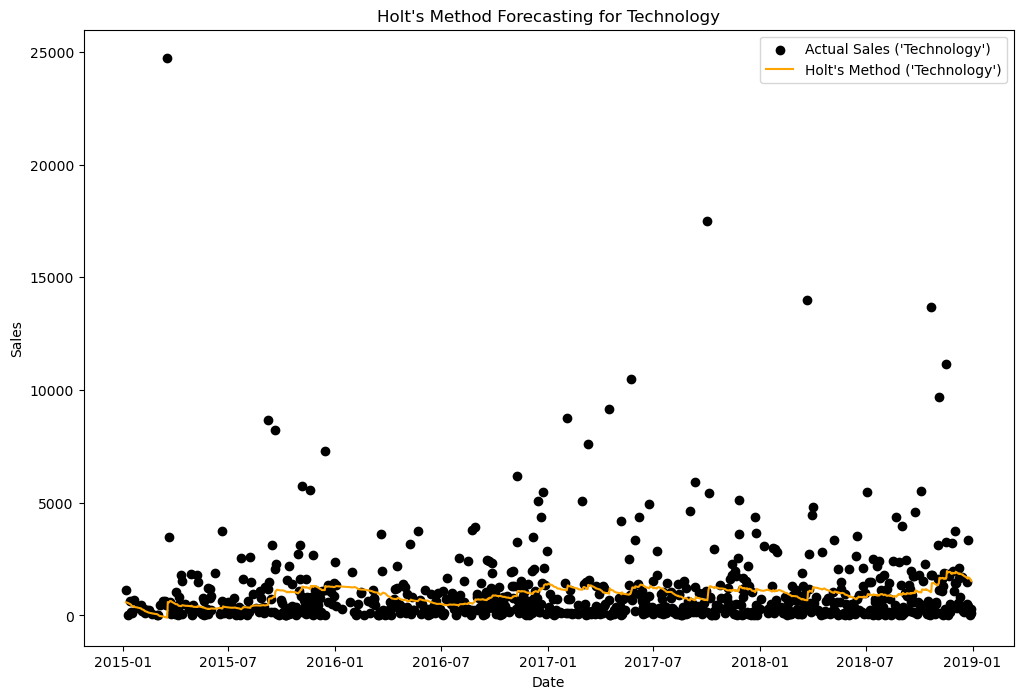

MSE: 3386263.9053412606, MAE: 951.3368847794287, MAPE: 7.7918658288232905


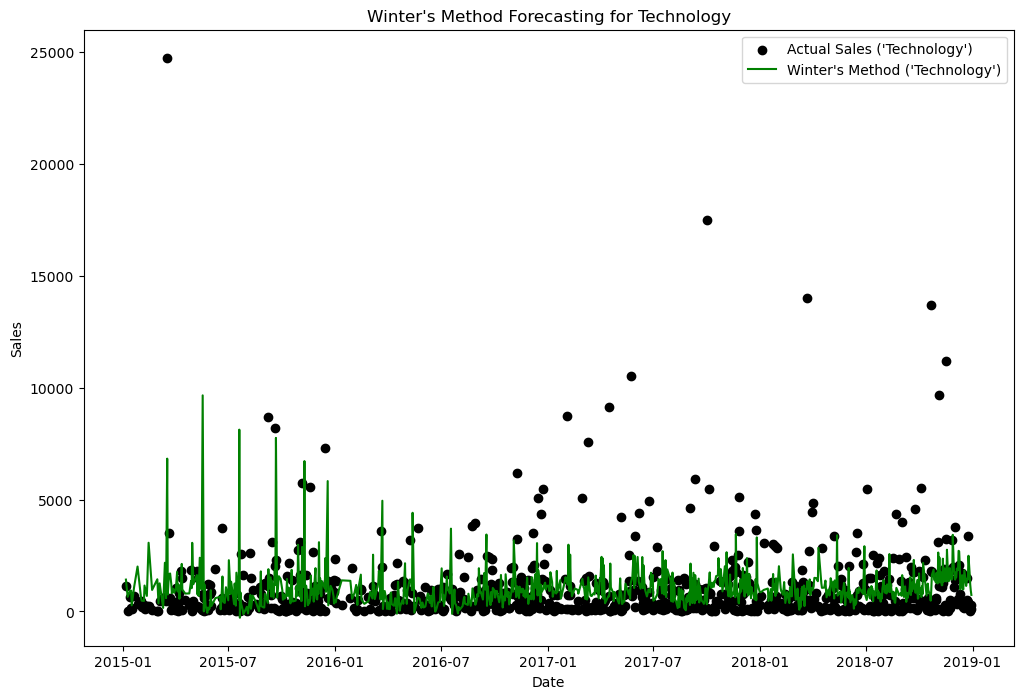

MSE: 3556240.826693548, MAE: 1067.1358411930214, MAPE: 9.912532330561243


,Category,Method,MSE,MAE,MAPE
0,Office Supplies,Moving Average,7.562208e+05,504.844125,5.902187
1,Office Supplies,Exponential Smoothing,1.033419e+06,589.606494,7.360548
2,Office Supplies,Linear Regression,9.598406e+05,578.378120,8.970303
3,Office Supplies,Deseasonalized Linear Regression,8.952217e+05,551.702862,7.577438
4,Office Supplies,Holt's Method,9.875606e+05,600.464778,8.885765
5,Office Supplies,Winter's Method,1.003664e+06,594.452003,8.373710
6,Furniture,Moving Average,7.835204e+05,610.376026,6.602820
7,Furniture,Exponential Smoothing,1.099838e+06,724.142556,8.079041
8,Furniture,Linear Regression,1.010831e+06,696.517042,8.332438
9,Furniture,Deseasonalized Linear Regression,9.216733e+05,664.023243,7.232736


In [120]:
categories = preprocessed_data['Category'].unique()
methods = {
    'Moving Average': moving_average,
    'Exponential Smoothing': exponential_smoothing,
    'Linear Regression': linear_regression,
    'Deseasonalized Linear Regression': deseasonalized_linear_regression,
    "Holt's Method": holts_method,
    "Winter's Method": winters_method
}

performance_metrics = []

for category in categories:
    print(f'Category: {category}')
    for method_name, method_func in methods.items():
        mse, mae, mape = method_func(category)
        performance_metrics.append({
            'Category': category,
            'Method': method_name,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape
        })

performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics